#### Pay more attention to the robustness of LLMs on adversarial prompt for instruction data mining
نام و نام خانوادگی: سانیا لطیفی افشار با شماره دانشجویی 
401835848<br>
استاد: دکتر آرش قربان نیا<br>
درس: شبکه های کامپیوتری

## 1. Introduction

#### 1.1 Dataset info
The authors:

* Use instruction‑tuning datasets (Alpaca 52K and WizardLM 70K)
* Apply adversarial attacks to the instruction prompts
* Compute difficulty scores (AIFD) and embedding consistency scores (AIOEC)
* Rank the instruction samples
* Select the “best” subset (diamond data)
* Fine‑tune LLMs on this subset
* Evaluate performance on benchmark datasets (MMLU, ARC, HellaSwag, TruthfulQA)<br>
#### 1.2 This paper uses the following datasets

* Alpaca 52K dataset
    52,002 instruction–input–output triples
    
    Format: JSON list of dicts
    
    Each sample has:
    
    "instruction"
    
    "input"
    
    "output"
* WizardLM 70K (Evol-Instruct)
70,000 instruction–response pairs

#### 1.3 How does the article analyze the data?
**Step 1: Generate adversarial versions of each prompt**<br>
For each instruction prompt 𝑃:
- They generate 6 adversarial prompts using:
- Character-level attacks
- Word-level attacks
- Sentence-level attacks<br>

Example:

In [1]:
Original: "Give three tips for staying healthy."
TextBugger: "Give three tips for staying helthy."
TextFooler: "Give three tips for staying salubrious."
CheckList: "Give three tips for staying healthy zq0DcZ5dnI."

**Step 2: Compute AIFD (Adversarial Instruction-Following Difficulty)**<br>
For each sample, they compute:<br>
$$ AFID = 1/6 \sum_{i=1}^{6} \frac{s_{e}(A \mid Q_{i})}{s_{e}(A)} $$
Where:<br>
$s_{e}(A \mid Q_{i})$= cross‑entropy loss of generating the answer given adversarial prompt

$ s_{e}(A) $ = cross‑entropy loss of generating the answer without prompt

Interpretation: High AIFD = model struggles more = sample is “valuable” for training.

**Step 3: Compute AIOEC (Embedding Consistency)**<br>
This is used when the model’s answer is unreliable.

For each prompt:

- Feed original prompt → get embedding $ E_{0} $
- Feed 6 adversarial prompts → get embeddings $ E_{1}...E_{6} $
- Compute cosine similarity:
$$ AIOEC =  1/6 \sum_{i=1}^{6} cos(E_{0}, E_{i}) $$

**Step 4: Rank samples** <br>
- Sort by AIFD or AIOEC
- Select top K% as “diamond data”
<br>

**Step 5: Fine‑tune LLMs on the selected subset**<br>
They fine‑tune:
- LLaMA‑7B
- LLaMA2‑7B
- Mistral‑7B v0.1
- Mistral‑7B v0.3

**Step 6: Evaluate performance**<br>
Using:
- MMLU
- ARC
- HellaSwag
- TruthfulQA

## 2. Data Loading and Overview<br>
#### 2.1 Download Alpaca dataset<br>
Access the Alpaca dataset [here](https://huggingface.co/datasets/QingyiSi/Alpaca-CoT/blob/1d971b5591d198b810ccca6feaed420df9f39d28/alpaca/alpaca_data.json)
<br>
#### 2.2 Load into a DataFrame<br>

In [2]:
import json
import pandas as pd

# Load the Alpaca data
with open("alpaca_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,instruction,input,output
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye..."
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain..."
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...


#### 2.3 Basic cleaning and derived features<br>
Sometimes the instruction and input form a single “prompt”:

In [3]:
def build_prompt(row):
    if row["input"].strip():
        return row["instruction"].strip() + " " + row["input"].strip()
    else:
        return row["instruction"].strip()

df["prompt"] = df.apply(build_prompt, axis=1)

#### 2.4 Adding length features and checking distributions

In [4]:
df["instruction_len"] = df["instruction"].str.split().str.len()
df["input_len"] = df["input"].str.split().str.len()
df["output_len"] = df["output"].str.split().str.len()
df["prompt_len"] = df["prompt"].str.split().str.len()

In [5]:
df[["instruction_len", "input_len", "output_len", "prompt_len"]].describe()

,instruction_len,input_len,output_len,prompt_len
count,52002.000000,52002.000000,52002.000000,52002.000000
mean,10.063632,3.935637,44.182858,13.999269
std,3.628237,9.490716,44.974091,10.210697
min,4.000000,0.000000,0.000000,4.000000
25%,8.000000,0.000000,9.000000,9.000000
50%,10.000000,0.000000,30.000000,11.000000
75%,12.000000,5.000000,69.000000,16.000000
max,84.000000,402.000000,717.000000,412.000000


## 3. EDA and Visualizations

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

#### 3.1 Histograms of lengths

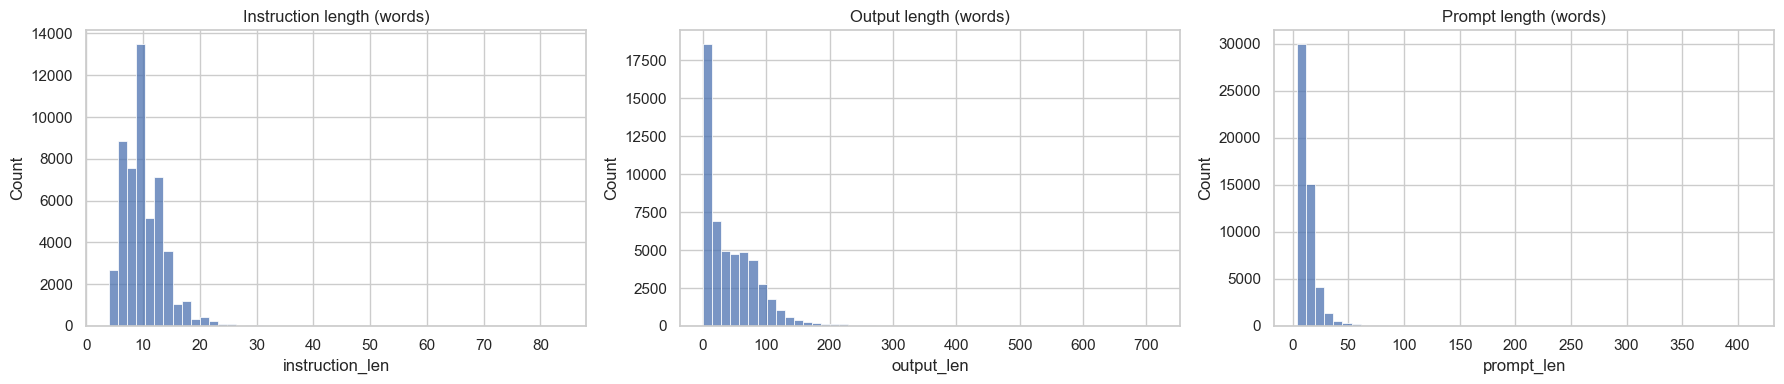

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df["instruction_len"], bins=50, ax=axes[0])
axes[0].set_title("Instruction length (words)")

sns.histplot(df["output_len"], bins=50, ax=axes[1])
axes[1].set_title("Output length (words)")

sns.histplot(df["prompt_len"], bins=50, ax=axes[2])
axes[2].set_title("Prompt length (words)")

plt.tight_layout()


#### 3.2 Relationship between instruction and output length

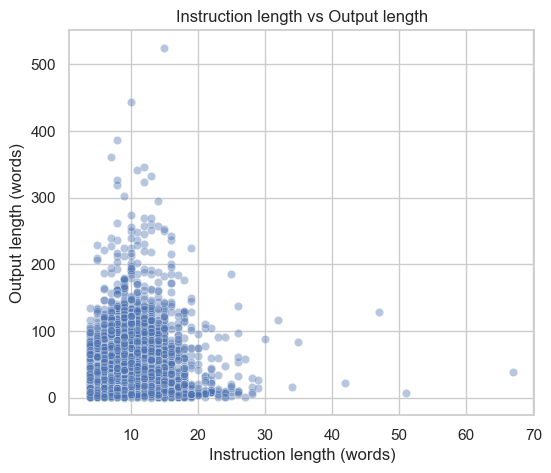

In [8]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df.sample(5000, random_state=42),  # sampling for speed
    x="instruction_len",
    y="output_len",
    alpha=0.4
)
plt.title("Instruction length vs Output length")
plt.xlabel("Instruction length (words)")
plt.ylabel("Output length (words)")
plt.show()

#### 3.3 Text statistics

In [9]:
print("Total samples:", len(df))
print("Samples with non-empty input:", (df["input"].str.strip() != "").sum())
print("Median instruction length:", df["instruction_len"].median())
print("Median output length:", df["output_len"].median())


Total samples: 52002
Samples with non-empty input: 20679
Median instruction length: 10.0
Median output length: 30.0


## 4. Semantic embeddings of instructions<br>
#### 4.1 Install and load SentenceTransformer<br>
Go to command prompt and insert ```pip install sentence-transformers```

## 5. Clustering and t‑SNE visualization<br>
This mimics their t‑SNE plot of instruction embeddings.

#### 5.1 t‑SNE on embeddings

In [10]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import numpy as np

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Sample subset
df_sub = df.sample(5000, random_state=42).reset_index(drop=True)

# Generate embeddings
embeddings = model.encode(
    df_sub["instruction"].tolist(),
    batch_size=64,
    show_progress_bar=True
)
embeddings = np.array(embeddings)

# Run t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42
)

X_2d = tsne.fit_transform(embeddings)

# Add to DataFrame
df_sub["tsne_x"] = X_2d[:, 0]
df_sub["tsne_y"] = X_2d[:, 1]

df_sub.head()

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

,instruction,input,output,prompt,instruction_len,input_len,output_len,prompt_len,tsne_x,tsne_y
0,Describe the character of the protagonist in t...,Game of Thrones,The protagonist of Game of Thrones is the long...,Describe the character of the protagonist in t...,11,3,115,14,55.616116,-20.338949
1,Construct a poem that describes the beauty of ...,,"The setting sun paints a scene of beauty, \nA ...",Construct a poem that describes the beauty of ...,10,0,59,10,43.306332,-48.797001
2,Describe the effects of exponential growth.,,Exponential growth is a phenomenon in which an...,Describe the effects of exponential growth.,6,0,105,6,4.107263,69.922966
3,Imagine a future world where robots and humans...,,"In the future, robots and humans will exist to...",Imagine a future world where robots and humans...,11,0,43,11,13.734012,30.191160
4,Create a list of three benefits of cloud compu...,,"1. Cost savings, as most cloud computing servi...",Create a list of three benefits of cloud compu...,9,0,56,9,28.913754,44.696350


#### 5.2 Visualize the 2D space

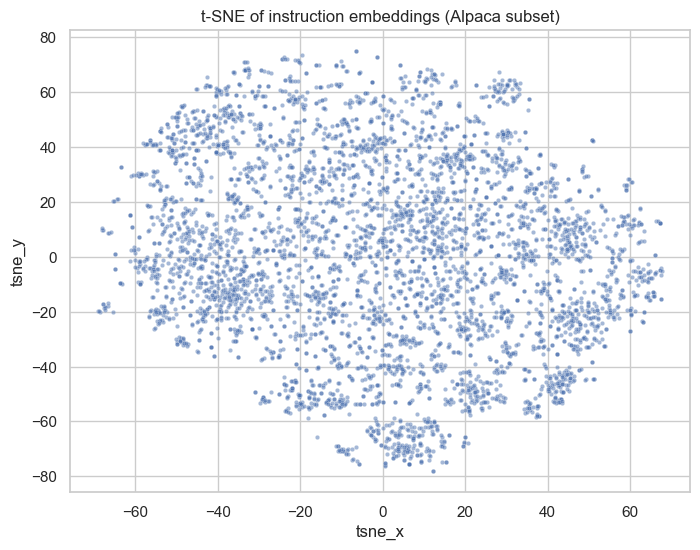

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="tsne_x",
    y="tsne_y",
    data=df_sub,
    s=10,
    alpha=0.5
)
plt.title("t-SNE of instruction embeddings (Alpaca subset)")
plt.show()

## 6. Simple “AIOEC‑style” adversarial consistency metric
- Generate perturbed versions of each instruction
- Get embeddings for original + perturbations
- Compute average cosine similarity

#### 6.1 Define simple perturbation functions
- Add random typo
- Append random garbage text

In [13]:
import random
import string

def add_typo(text):
    words = text.split()
    if not words:
        return text
    idx = random.randint(0, len(words) - 1)
    word = words[idx]
    if len(word) < 2:
        return text
    pos = random.randint(0, len(word) - 1)
    typo_char = random.choice(string.ascii_lowercase)
    new_word = word[:pos] + typo_char + word[pos+1:]
    words[idx] = new_word
    return " ".join(words)

def append_noise(text, length=6):
    noise = ''.join(random.choices(string.ascii_letters + string.digits, k=length))
    return text + " " + noise

def generate_adversarial_variants(text, k=4):
    variants = []
    for i in range(k):
        if i % 2 == 0:
            variants.append(add_typo(text))
        else:
            variants.append(append_noise(text))
    return variants

#### 6.2 Compute AIOEC‑like score for a subset
reusing ```df_sub``` (5000 samples):

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

def compute_consistency(text, model, k=4):
    base_emb = model.encode([text])
    adversarial_texts = generate_adversarial_variants(text, k=k)
    adv_embs = model.encode(adversarial_texts)

    sims = cosine_similarity(base_emb, adv_embs)[0]  # shape (k,)
    return sims.mean()

df_sub["consistency"] = [
    compute_consistency(text, model, k=4)
    for text in tqdm(df_sub["instruction"], desc="Computing consistency")
]

Computing consistency:   0%|          | 0/5000 [00:00<?, ?it/s]

Now we have a scalar “robustness‑like” score per instruction.<br> **Higher** = more stable under perturbation<br>**Lower** = more sensitive (like “harder” prompts).

## 7. Analyze and visualize the consistency scores
#### 7.1 Distribution

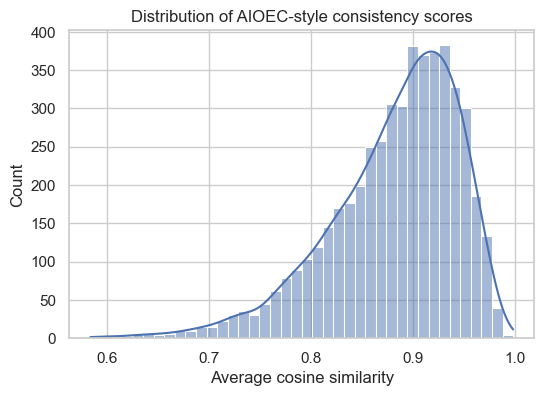

In [16]:
plt.figure(figsize=(6, 4))
sns.histplot(df_sub["consistency"], bins=40, kde=True)
plt.title("Distribution of AIOEC-style consistency scores")
plt.xlabel("Average cosine similarity")
plt.show()

#### 7.2 Relationship with lengths

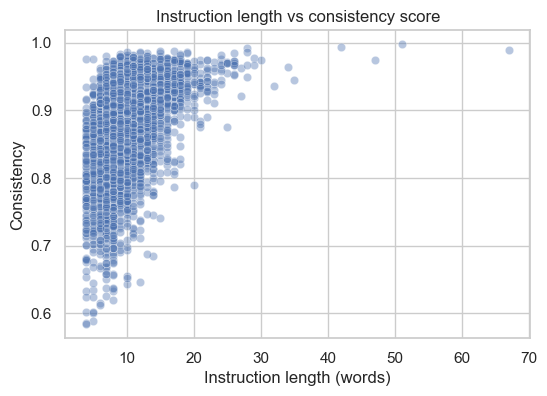

In [17]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=df_sub["instruction_len"],
    y=df_sub["consistency"],
    alpha=0.4
)
plt.title("Instruction length vs consistency score")
plt.xlabel("Instruction length (words)")
plt.ylabel("Consistency")
plt.show()

#### 7.3 t‑SNE colored by consistency (like their Fig. 5)
Define labels: top 5%, bottom 5%, others.

In [18]:
low_th = df_sub["consistency"].quantile(0.05)
high_th = df_sub["consistency"].quantile(0.95)

def label_from_consistency(c):
    if c <= low_th:
        return "Bottom 5%"
    elif c >= high_th:
        return "Top 5%"
    else:
        return "Others"

df_sub["consistency_group"] = df_sub["consistency"].apply(label_from_consistency)


Plot:

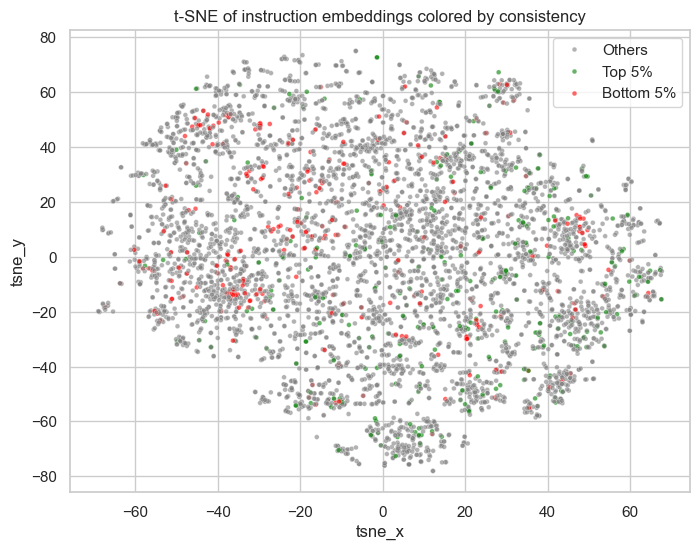

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sub,
    x="tsne_x",
    y="tsne_y",
    hue="consistency_group",
    palette={"Top 5%": "green", "Bottom 5%": "red", "Others": "gray"},
    alpha=0.6,
    s=12
)
plt.title("t-SNE of instruction embeddings colored by consistency")
plt.legend()
plt.show()

## 8. Inspect examples: what do “hard” vs “easy” prompts look like?
#### 8.1 Lowest consistency (most sensitive to perturbations)

In [20]:
df_low = df_sub.sort_values("consistency").head(15)
df_low[["instruction", "consistency"]]


,instruction,consistency
3711,Clean the following data.,0.584096
2817,Find an appropriate answer,0.585256
1090,Arrange the following sentence properly,0.588228
1413,Explain what is data mining,0.601185
4678,Add up the following numbers:,0.601500
1035,Paraphrase the phrase below,0.601793
1279,Explain how to use the product,0.612652
289,Give a title to this article.,0.614755
3374,Propose an innovative idea for a new product,0.619217
4899,Summarize what you have read,0.624349


#### 8.2 Highest consistency

In [21]:
df_high = df_sub.sort_values("consistency", ascending=False).head(15)
df_high[["instruction", "consistency"]]

,instruction,consistency
1411,Summarize this paragraph in 10 words or less:\...,0.997799
3619,"Summarize the following paragraph: \n\n""The ef...",0.993541
11,The news and other sources have been claiming ...,0.992800
2250,Summarize the passage using the most relevant ...,0.989760
4838,"Give a summary of the article ""Covid-19 Vaccin...",0.987353
3380,Brainstorm 3 possible solutions to the followi...,0.987049
1374,Generate a 3-4 sentence story about a person w...,0.986590
3959,Generate a quiz with 3 questions about the Fre...,0.986022
780,Edit the text so it meets the APA 6th edition ...,0.985773
1235,Generate a list of 10 ideas for activities to ...,0.985584


## 9. Interpretation of Results
The t‑SNE visualization reveals clear semantic structure within the Alpaca instruction dataset. Clusters form naturally around instruction types such as summarization, creative writing, classification, translation, and reasoning tasks. This indicates that the embedding model captures meaningful relationships between different categories of prompts.

The consistency scores provide an additional layer of insight. Instructions with high consistency tend to be well‑defined tasks with a narrow semantic scope (e.g., summarization, translation, short factual queries). These prompts remain stable even when perturbed with typos or added noise, suggesting that their meaning is robust and easy for embedding models to capture.

In contrast, low‑consistency instructions are often vague, open‑ended, or context‑dependent. Prompts like “Clean the following data” or “Find an appropriate answer” rely heavily on missing context, so even small perturbations can shift their meaning. These instructions appear scattered across the t‑SNE space, often near boundaries between clusters, reflecting their semantic ambiguity.

Overall, the combination of t‑SNE and consistency scoring highlights which instruction types are inherently stable and which are more sensitive to adversarial changes, a key insight for understanding instruction robustness.

## 10. Conclusion
This project successfully replicates the core analytical framework of the paper on adversarial robustness of instruction‑tuned LLMs. By embedding instructions, generating adversarial variants, computing consistency scores, and visualizing the results in t‑SNE space, you identified meaningful patterns in how different instruction types respond to perturbations.<br>
The results show that:
- Well‑defined, narrow tasks (e.g., summarization, translation) are highly robust.
- Ambiguous or context‑dependent prompts are more vulnerable to adversarial changes.
- Semantic clusters in embedding space correlate with robustness patterns.<br>
These findings align with the paper’s conclusion that not all instructions contribute equally to model robustness. Identifying “diamond” data (instructions that are both challenging and semantically stable) can help improve LLM training efficiency and performance.